In [1]:
from pymatreader import read_mat
import seaborn as sns
import xarray as xr
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from spectral_connectivity import Multitaper, Connectivity
import gc
import mne_connectivity

In [10]:
data = read_mat("coupling_strengths.mat")
data["Coupling_strengths"].shape

(68, 68, 201)

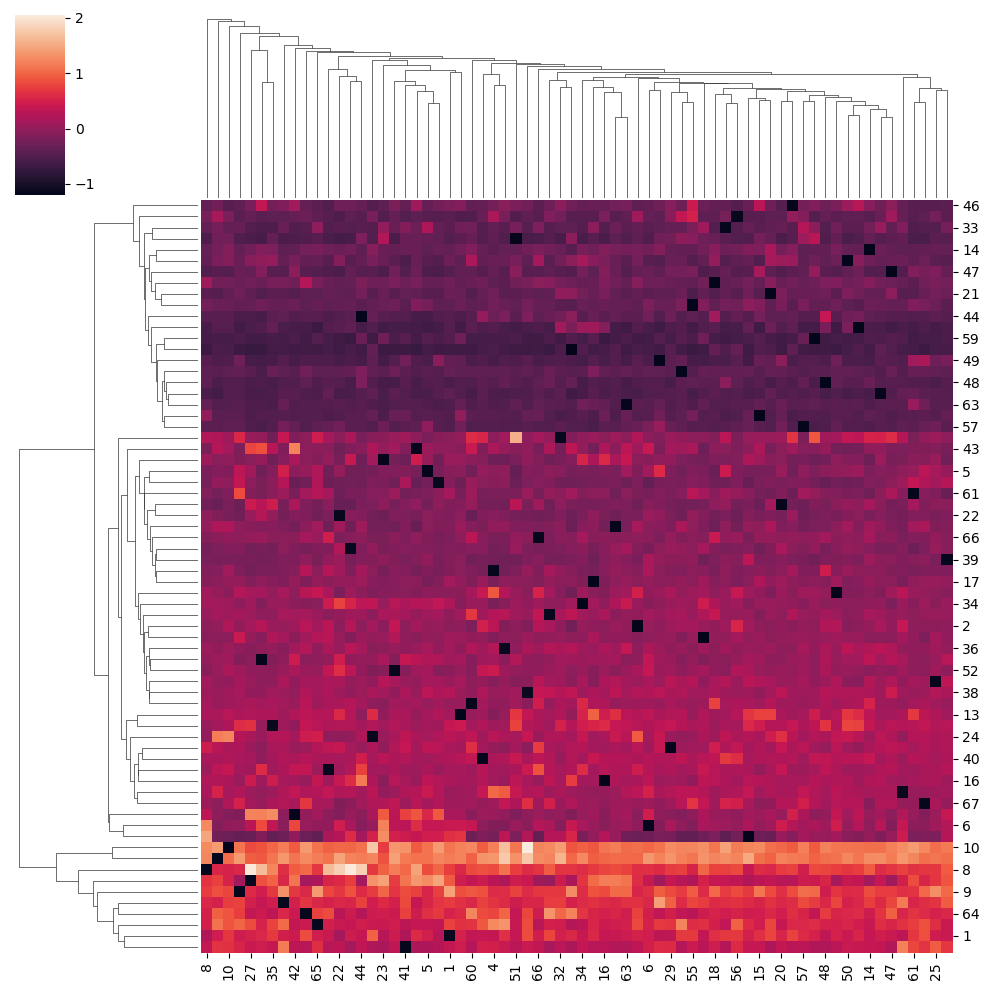

In [11]:
sns.clustermap(data["Coupling_strengths"].mean(2))

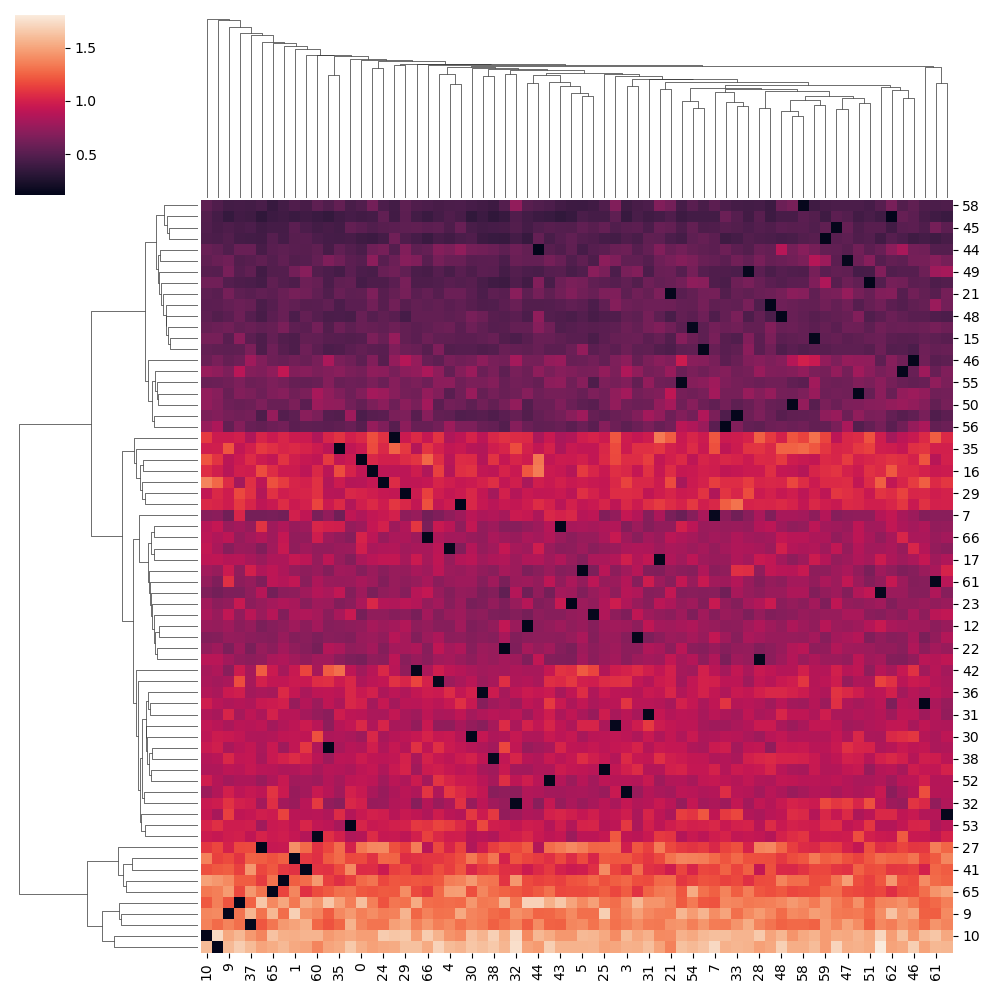

In [12]:
sns.clustermap(data["Coupling_strengths"].std(2))

In [2]:
sources_nc = xr.open_dataset("sub-s601_ses-m12_eeg_qcr_source_labels.nc")
sfreq = 500

In [3]:
sources_nc

<xarray.Dataset>
Dimensions:                        (time: 500, epoch: 201, region: 68)
Coordinates:
  * time                           (time) float64 -0.2 -0.198 ... 0.796 0.798
  * epoch                          (epoch) int32 0 1 2 3 4 ... 197 198 199 200
  * region                         (region) object 'bankssts-lh' ... 'transve...
Data variables:
    __xarray_dataarray_variable__  (epoch, region, time) float64 ...

In [4]:
sources_nc

AttributeError: 'Dataset' object has no attribute 'get_data'

In [14]:
# Needed to remove lru_cache usage from the connectivity.py file in order to control memory usage
methods_kramer = [  #'phase_locking_value',         # Use too much memory
                    #'pairwise_phase_consistency',  # Use too much memory
                    #'canonical_coherence',         # Require additional parameterization       
                    #'group_delay',                 # Raise an exception
                    #'debiased_squared_weighted_phase_lag_index' # Return only zeros
                    'pairwise_spectral_granger_prediction',
                    'generalized_partial_directed_coherence', 
                    'direct_directed_transfer_function', 
                    'coherency', 
                    'imaginary_coherence',
                    'directed_transfer_function',
                    'directed_coherence', 
                    'partial_directed_coherence',     
                    'phase_lag_index', 
                    'weighted_phase_lag_index', 
                    'debiased_squared_phase_lag_index']

kramer_cons = []
for method in methods_kramer:
    print(method)

    m = Multitaper(time_series=sources_nc.to_array().squeeze().data.transpose(2, 0, 1),
                   sampling_frequency=sfreq)

    c = Connectivity(fourier_coefficients=m.fft(),
                     frequencies=m.frequencies,
                     time=m.time)    
    
    con = getattr(c, method)()
    kramer_cons.append(np.nan_to_num(con.squeeze().mean(0), 0))    
    
    del m
    del c
    del con
    gc.collect()    

pairwise_spectral_granger_prediction


ValueError: axes don't match array

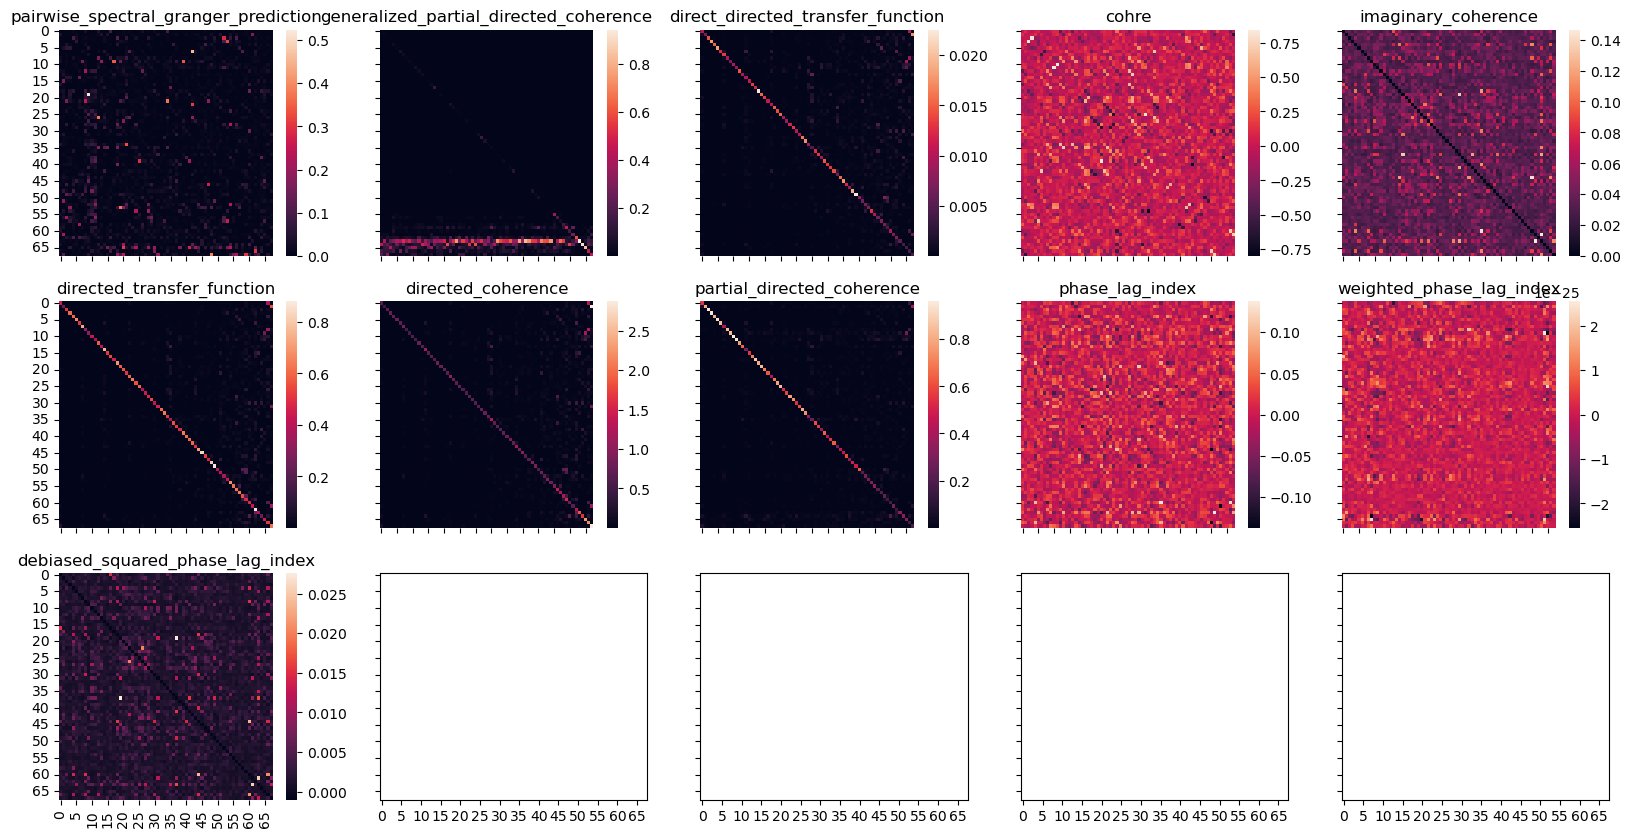

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10), sharex=True, sharey=True)
all_dat = []
for con_mat, method, ax in zip(kramer_cons, methods_kramer, axes.ravel()):
    if method == "coherency":
        method = "cohre"
        con_mat = np.real(con_mat)
    sns.heatmap(con_mat, ax=ax)
    ax.set_title(method)
    all_dat.append(con_mat.ravel())

In [8]:
mne_methods = ['coh', 'imcoh', 'cohy', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli', 'wpli2_debiased']

# mne.connectivity => mne_connectivity.sprectral_connectivity_epochs(...)
connect_epochs = mne_connectivity.spectral_connectivity_epochs(sources_nc.to_array().squeeze().data, 
                                                                               method=mne_methods, sfreq=sfreq, mode='multitaper', 
                                                                               fmin=None, fmax=np.inf, fskip=0, faverage=False, 
                                                                               tmin=None, tmax=None, mt_bandwidth=None, mt_adaptive=False, 
                                                                               mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..0.998s for estimation (500 points)
    frequencies: 5.0Hz..250.0Hz (246 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, Imaginary Coherence, Coherency, PLV, ciPLV, PPC, PLI, Unbiased PLI Square, WPLI, Debiased WPLI Square
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    comp

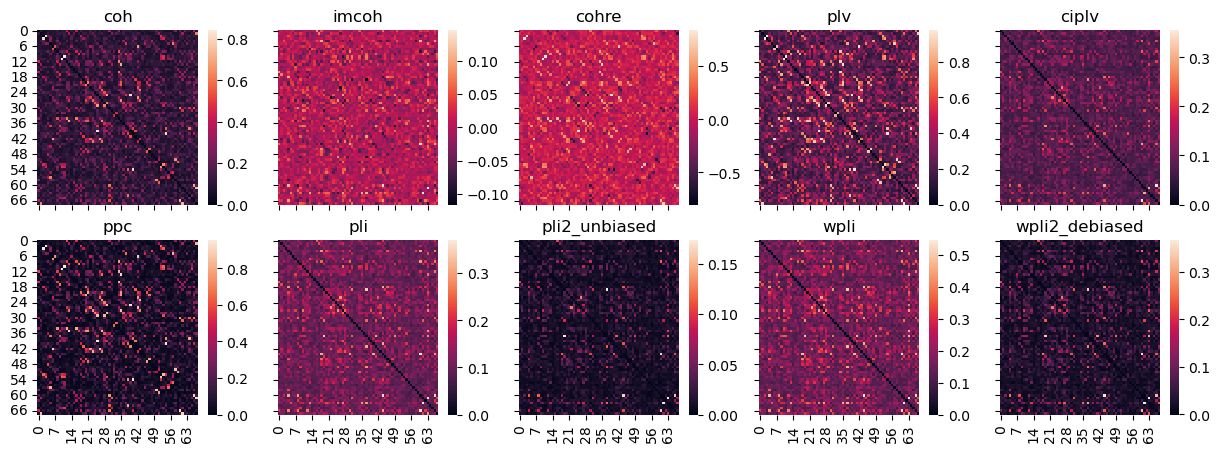

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharex=True, sharey=True)
mne_all_dat = []
for con_mat, method, ax in zip(connect_epochs, mne_methods, axes.ravel()):
    con_mat = np.real(con_mat.get_data(output='dense'))
    if method == "cohy":
        method = "cohre"
        #con_mat = np.real(con_mat)
    sns.heatmap(con_mat.mean(2) + con_mat.mean(2).T, ax=ax)
    ax.set_title(method)
    mne_all_dat.append((con_mat.mean(2) + con_mat.mean(2).T).ravel())

c:\Users\erikc\anaconda3\envs\NeuralNets\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


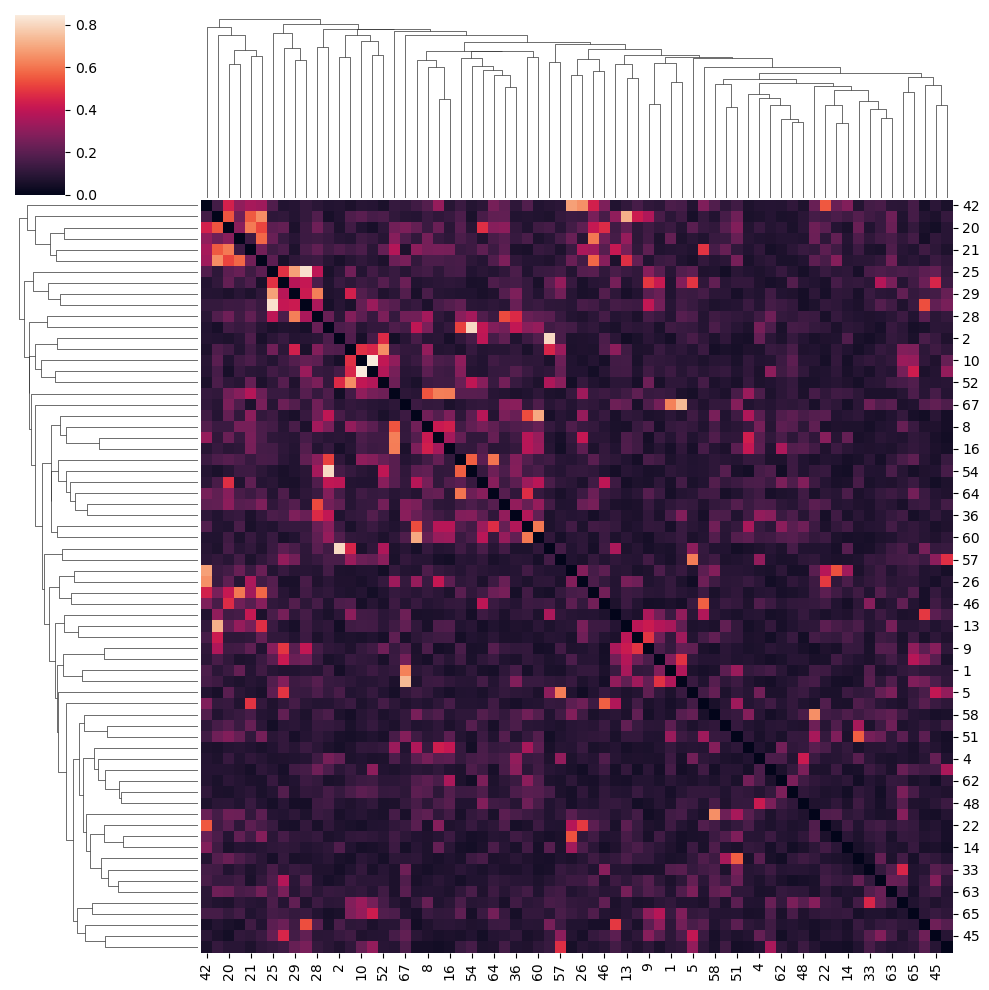

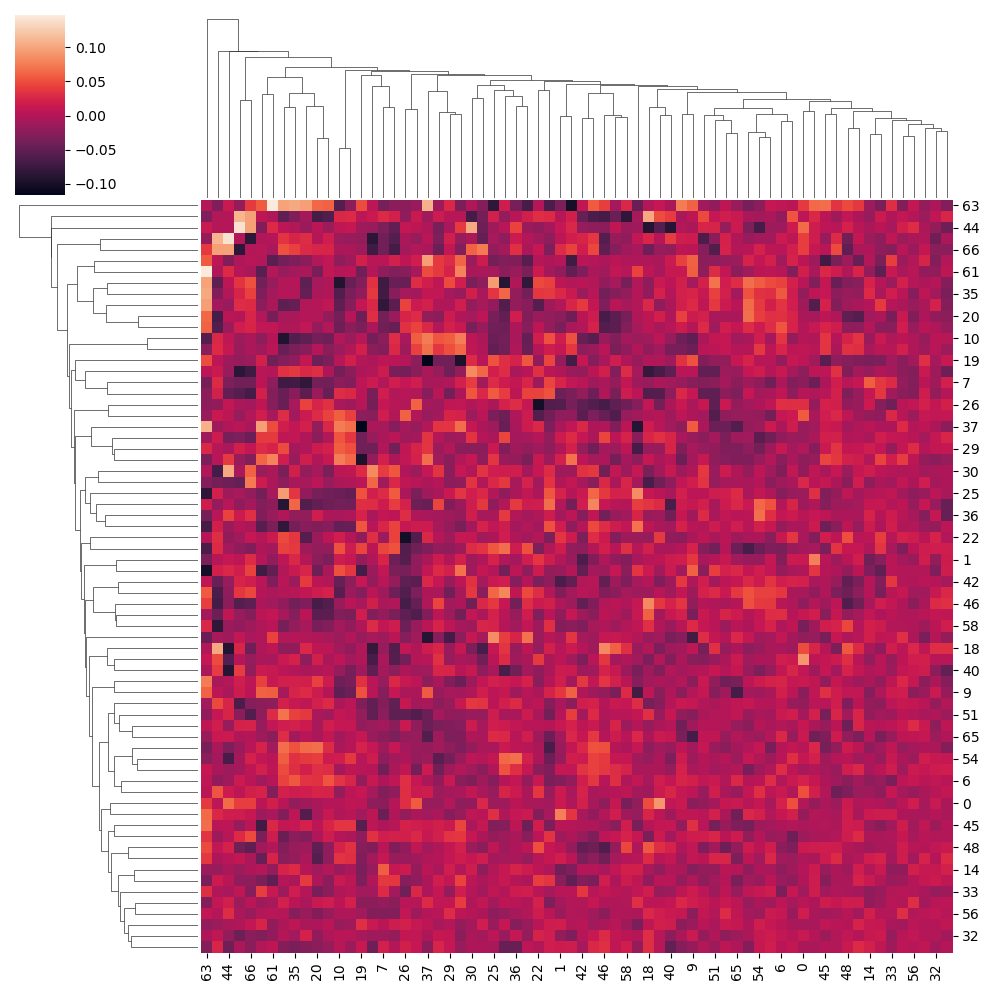

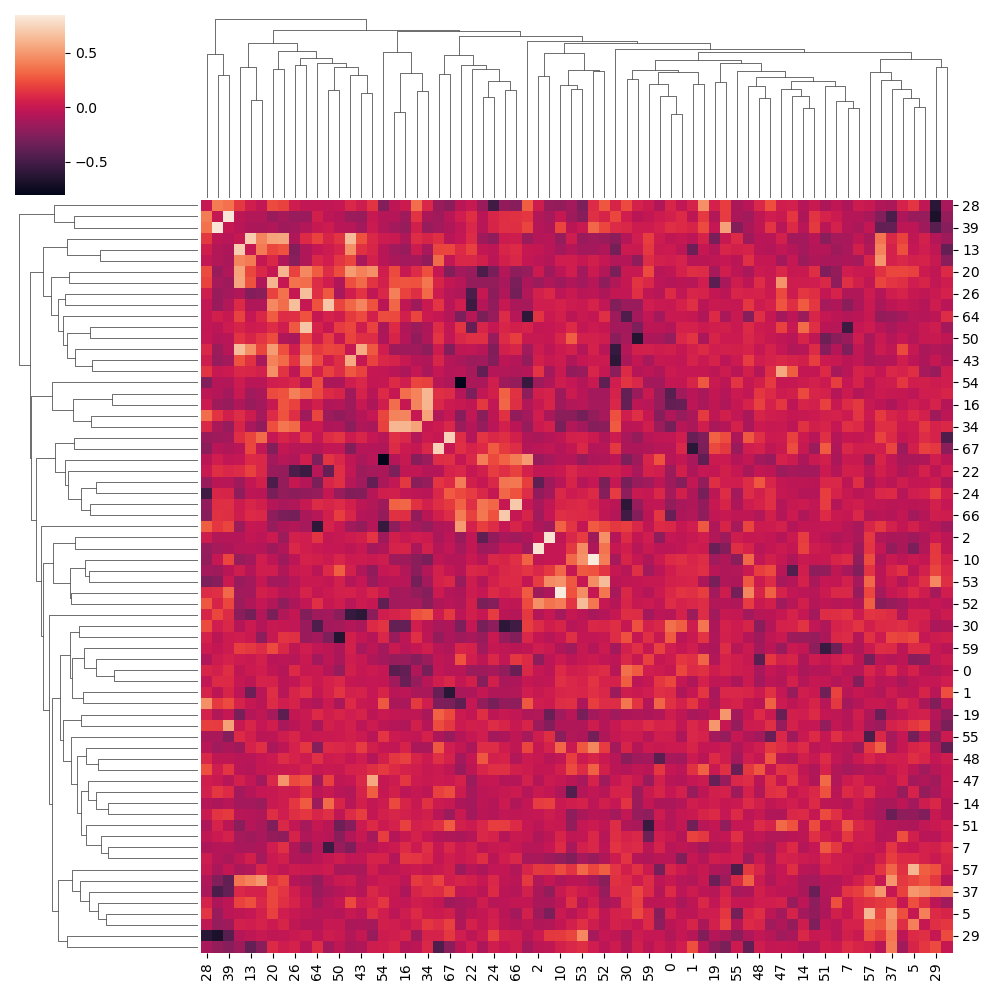

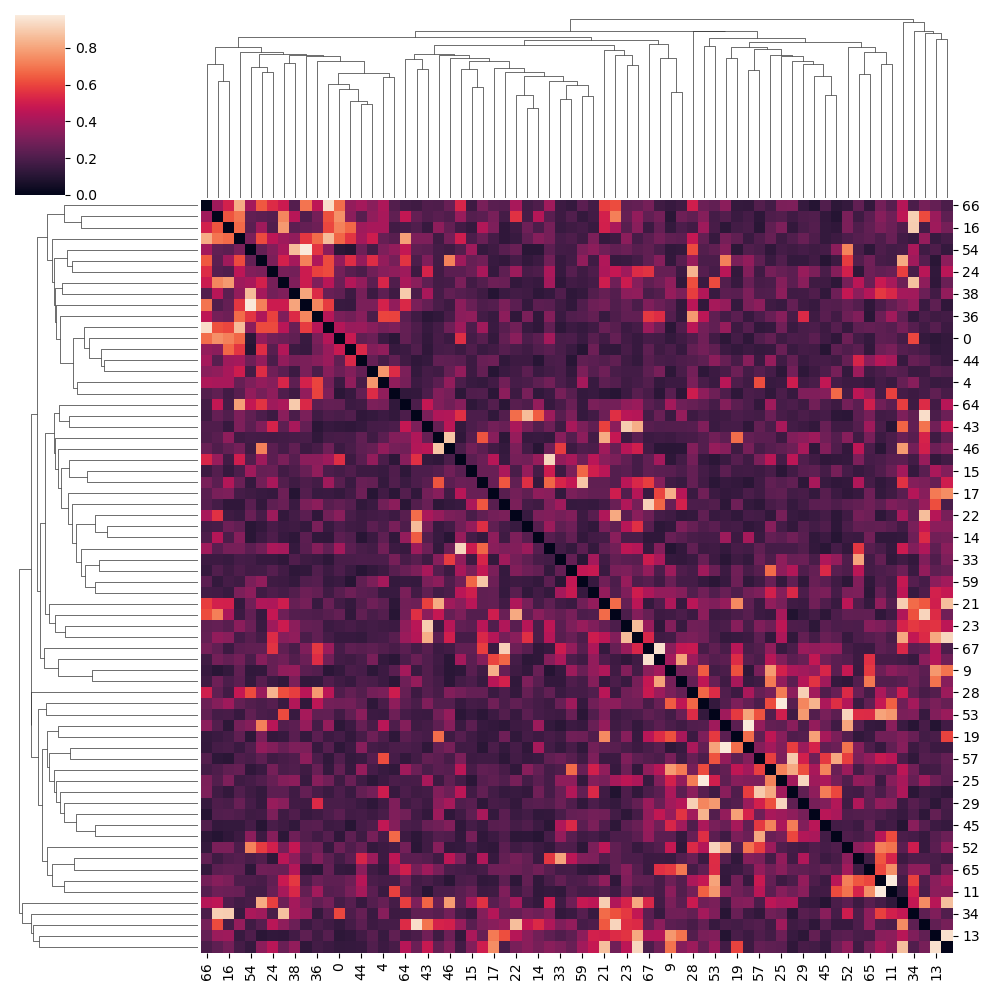

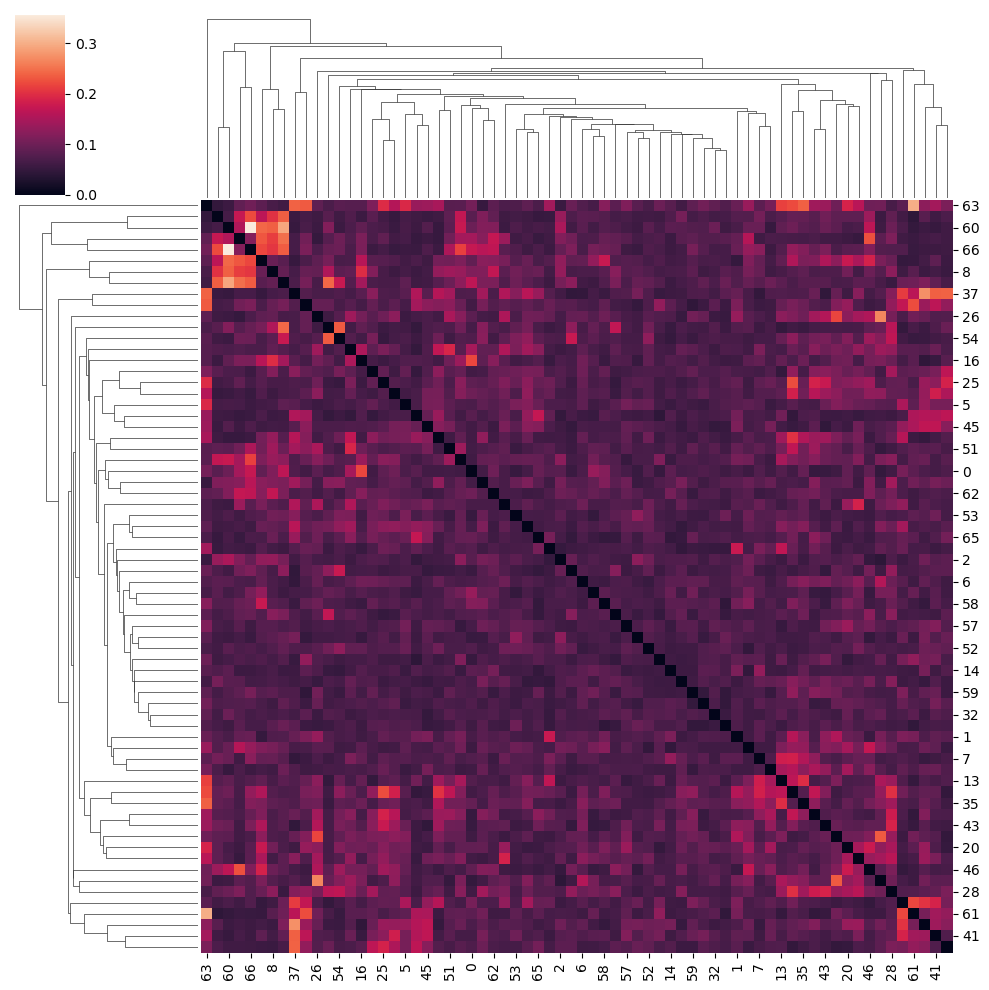

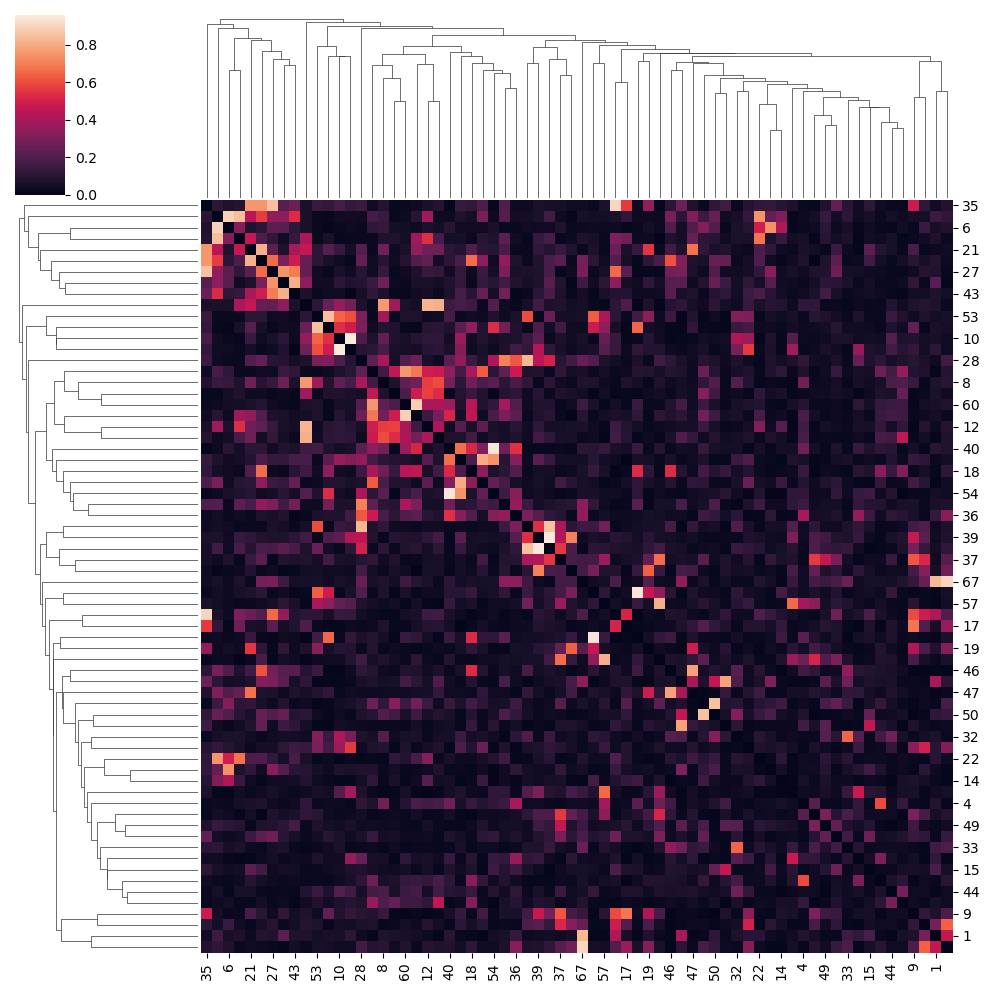

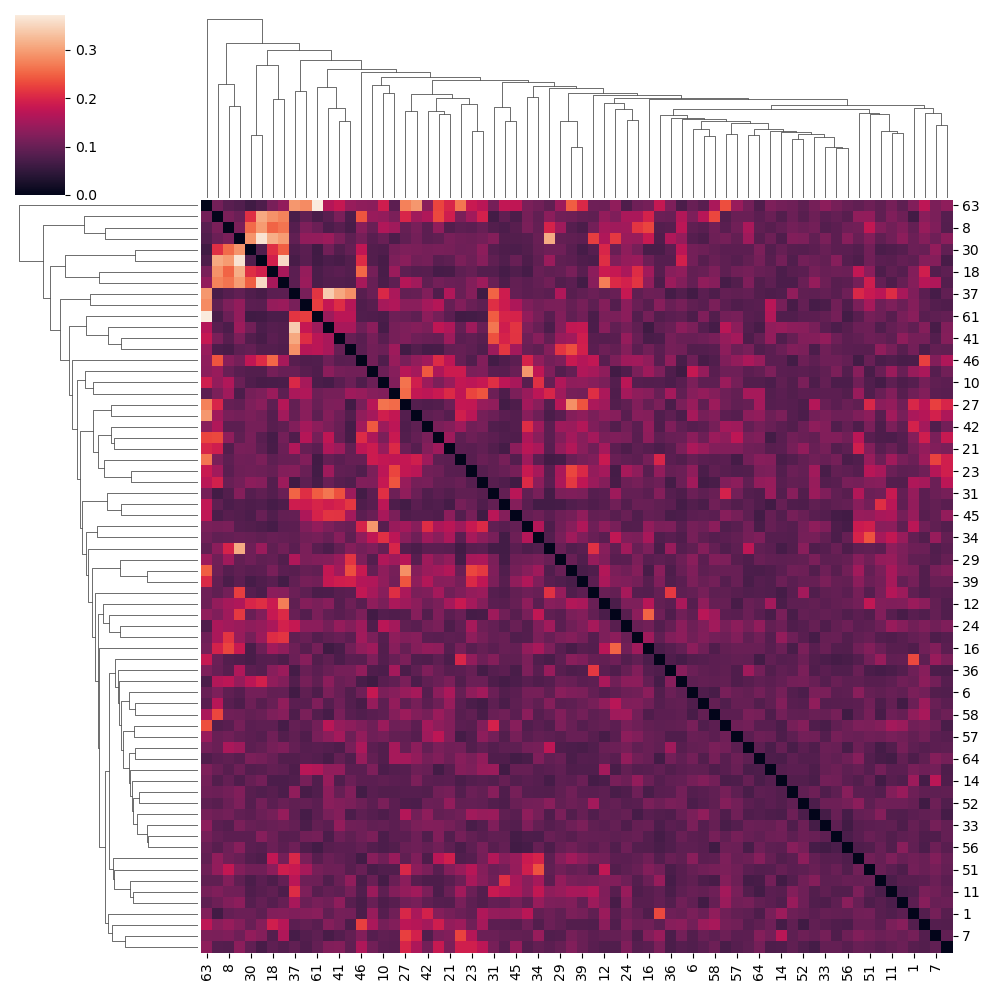

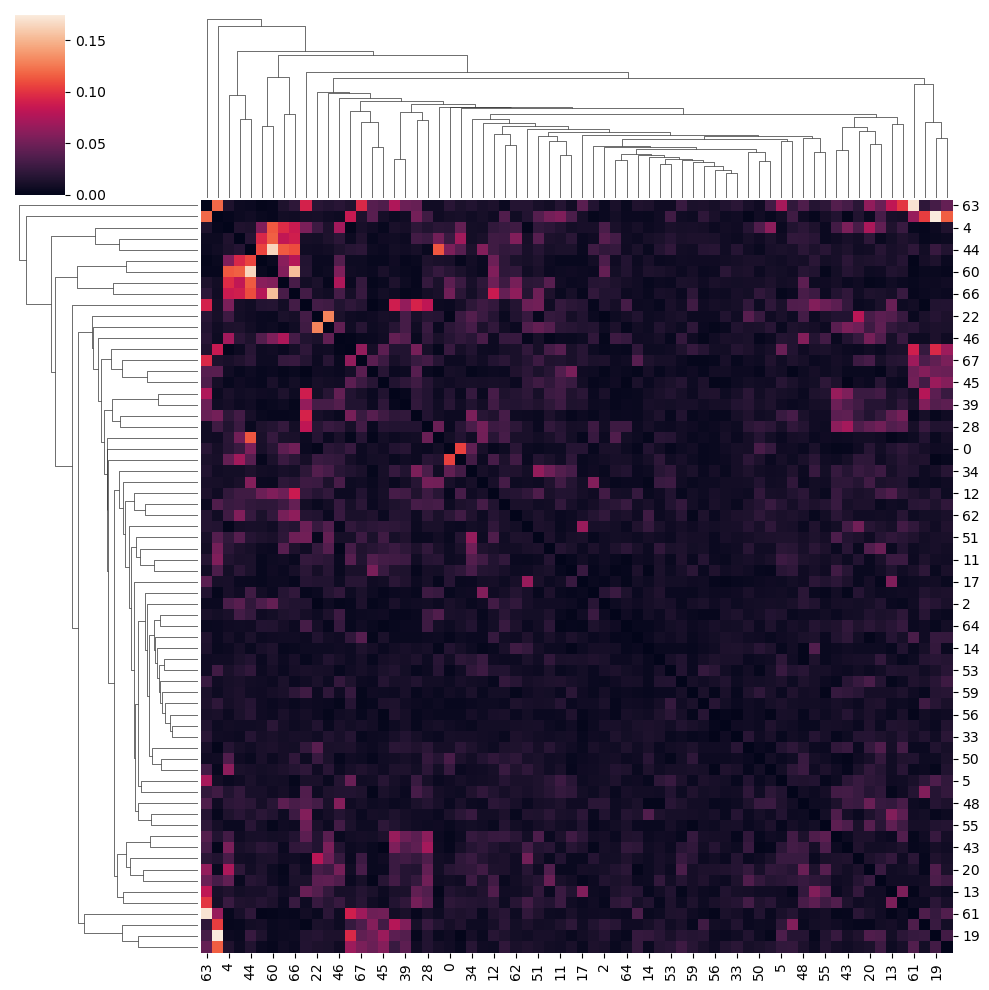

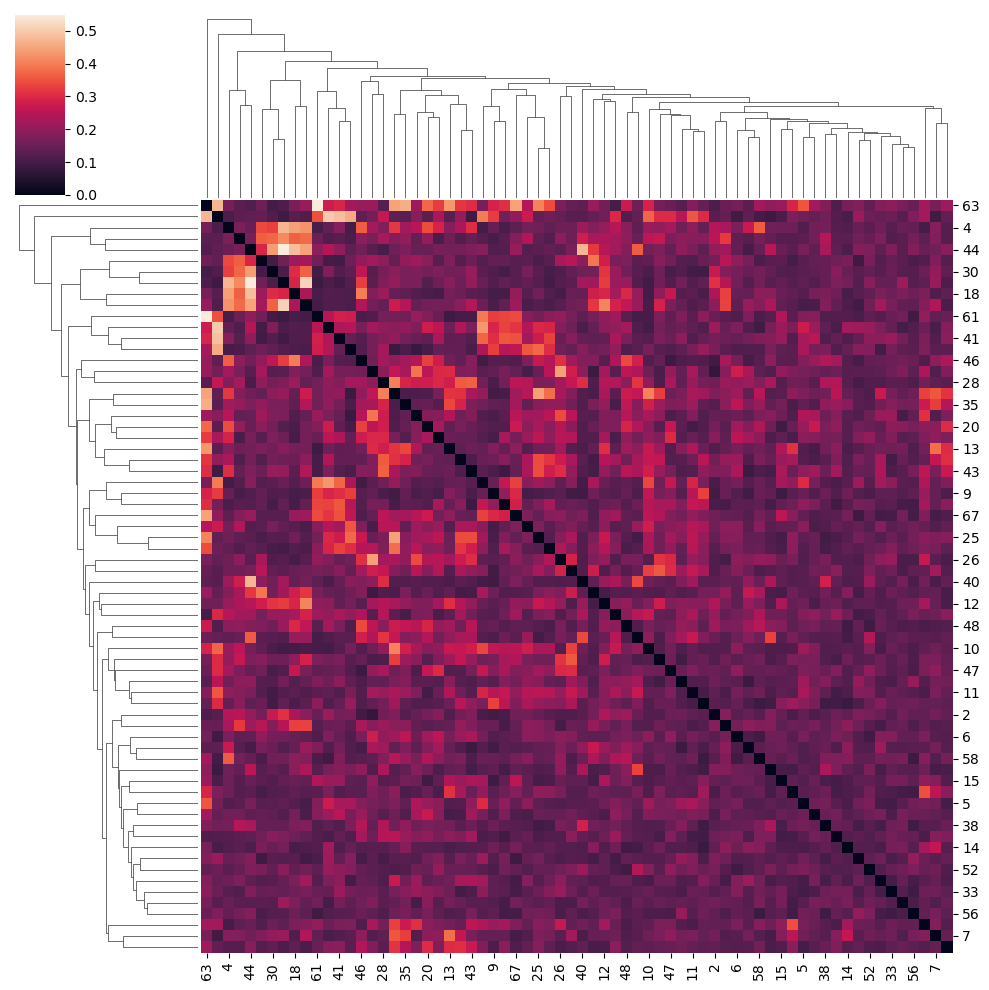

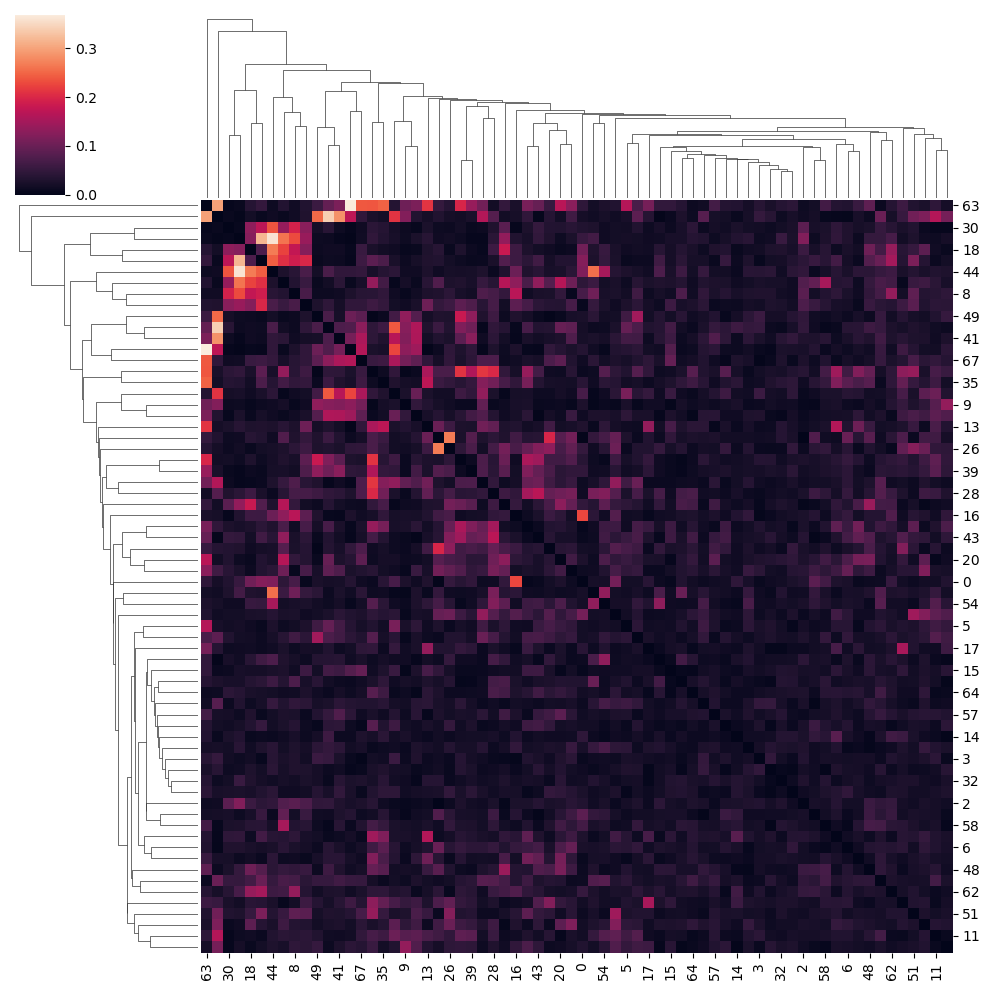

In [12]:
for con_mat, method, ax in zip(connect_epochs, mne_methods, axes.ravel()):
    con_mat = np.real(con_mat.get_data(output='dense'))
    if method == "cohy":
        method = "cohre"
        #con_mat = np.real(con_mat)

    sns.clustermap(con_mat.mean(2) + con_mat.mean(2).T)

In [13]:
all_methods = []

for method in mne_methods:
    if method == "cohy":
        all_methods.append("mne_cohre")        
    else:
        all_methods.append("mne_" + method)
for method in methods_kramer:
    if method == "coherency":
        all_methods.append("sc_cohre")        
    else:
        all_methods.append("sc_" + method)
all_methods.append("dynsys")

combined_dat = mne_all_dat.copy()
for con, method in zip(kramer_cons, methods_kramer):
    if method == "coherency":
        combined_dat.append(np.real(con).ravel())
    else:
        combined_dat.append(con.ravel())
    
    
combined_dat.append(data["Coupling_strengths"].mean(2).ravel())

<Axes: >

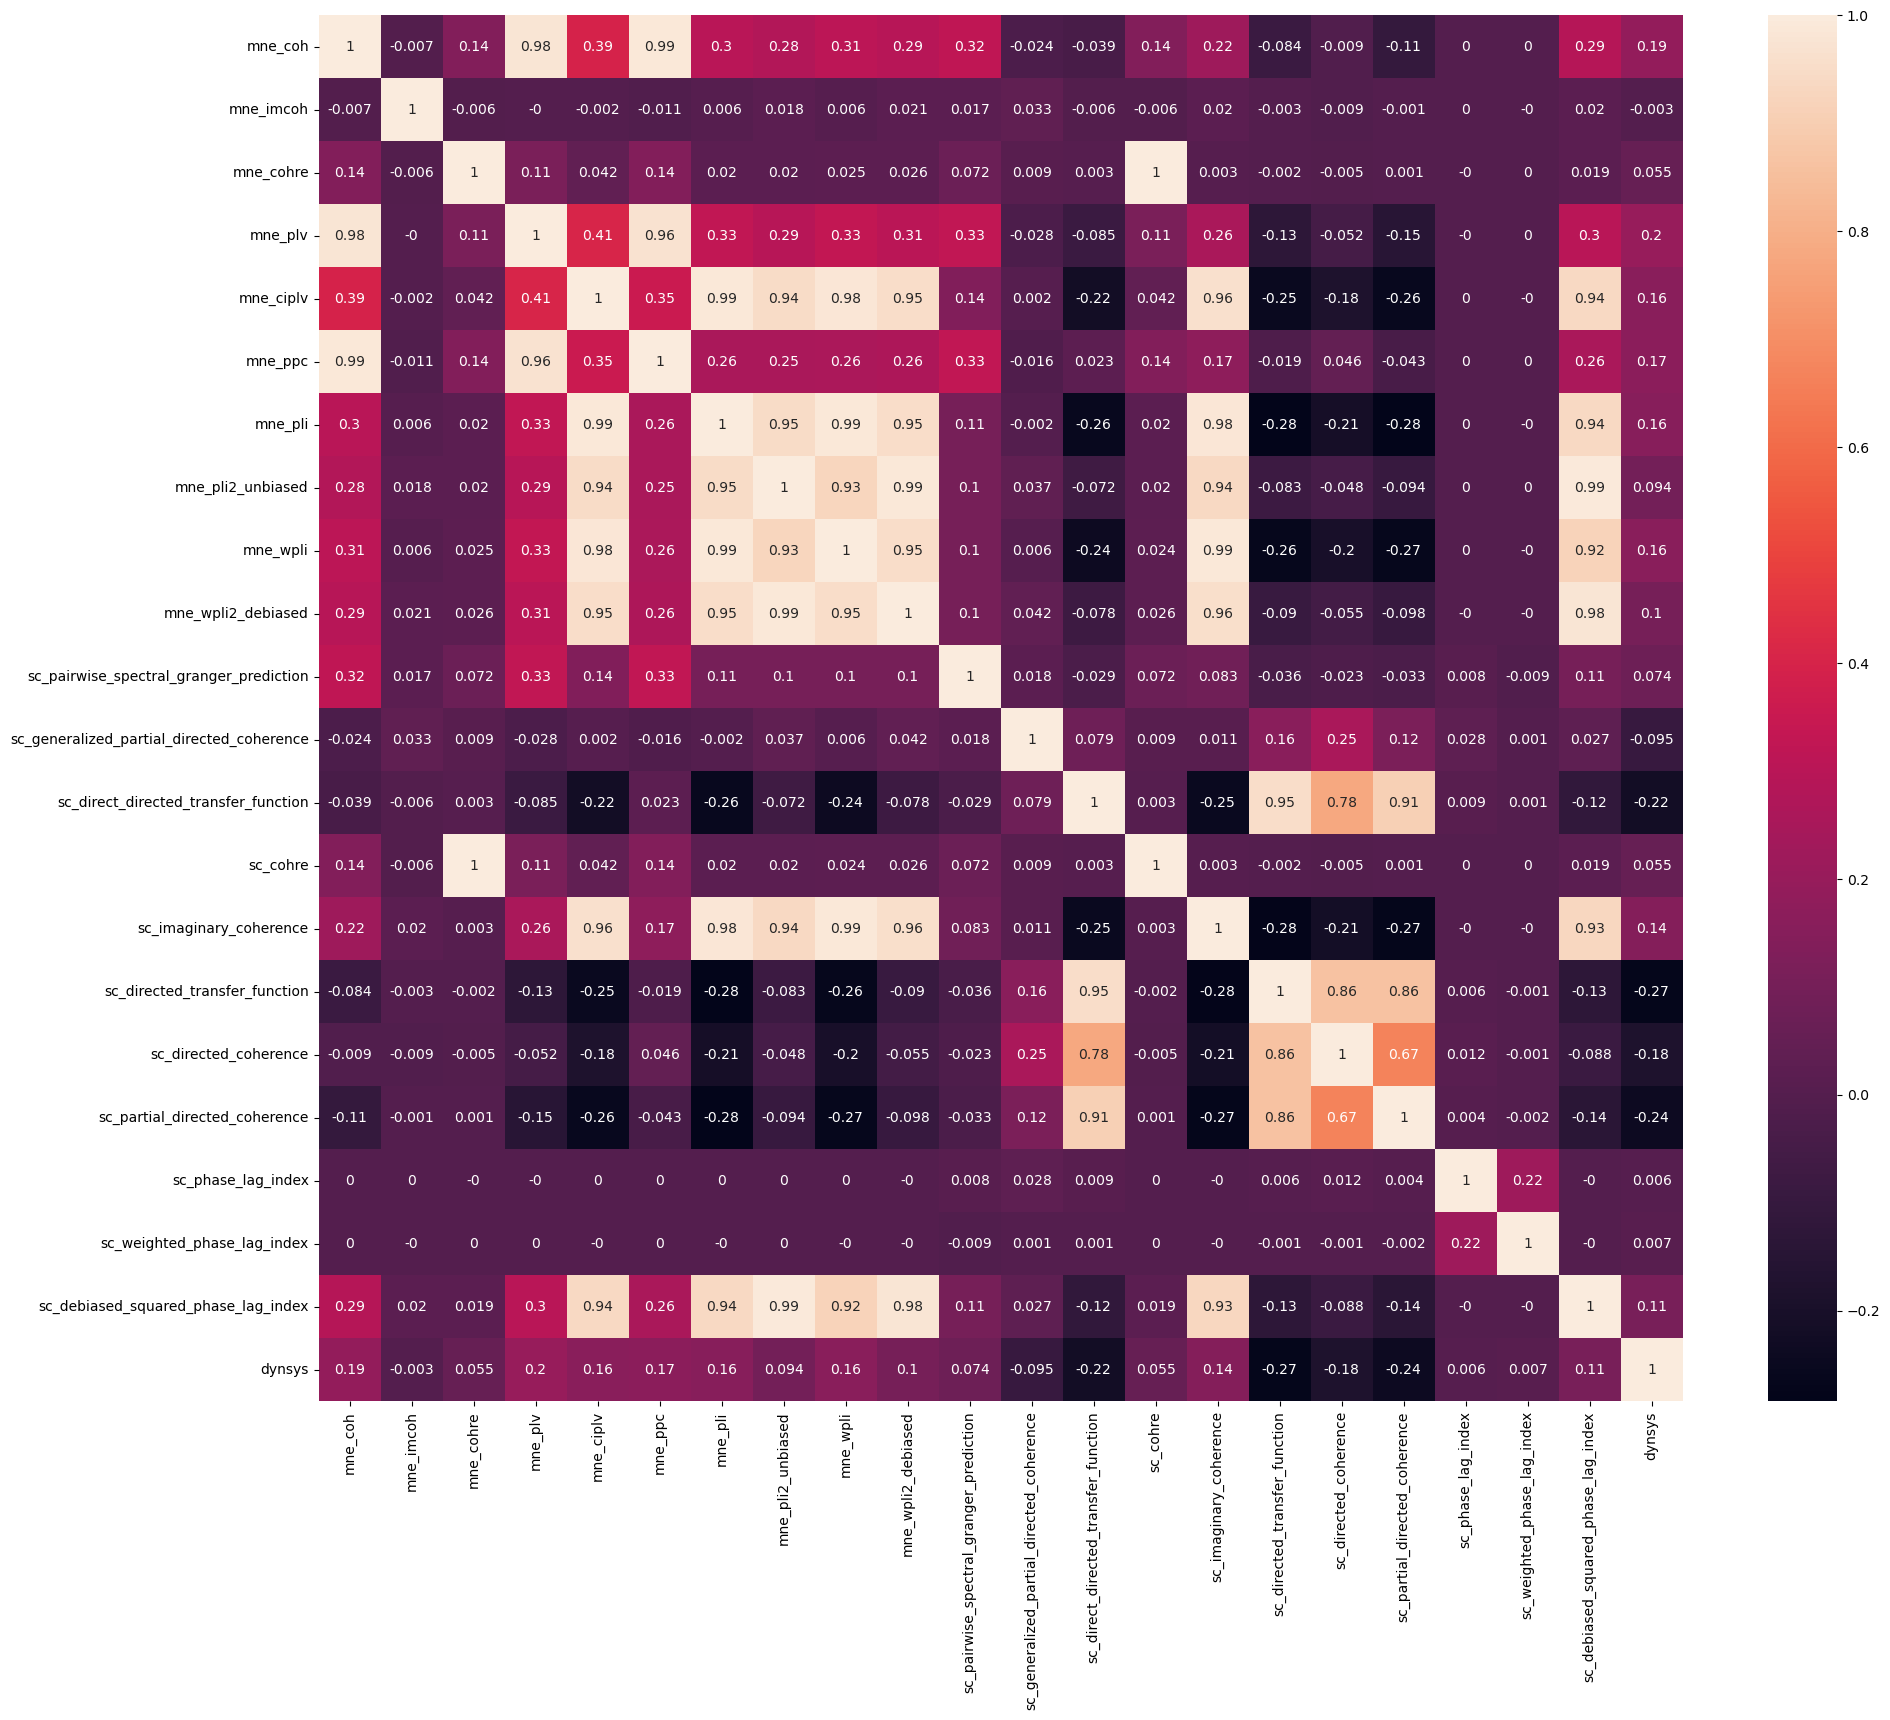

In [14]:
plt.figure(figsize=(22, 18))
sns.heatmap(np.round(pd.DataFrame(np.array(combined_dat).T, columns = all_methods).corr(), 3), annot=True)

In [15]:
rejected = ['mne_ppc', 'mne_plv', 'sc_cohre', 'mne_pli', 'mne_pli2_unbiased', 
            'mne_wpli', 'sc_directed_transfer_function', 'sc_directed_coherence', 
            'sc_phase_lag_index', 'sc_weighted_phase_lag_index', 
            'sc_debiased_squared_phase_lag_index']

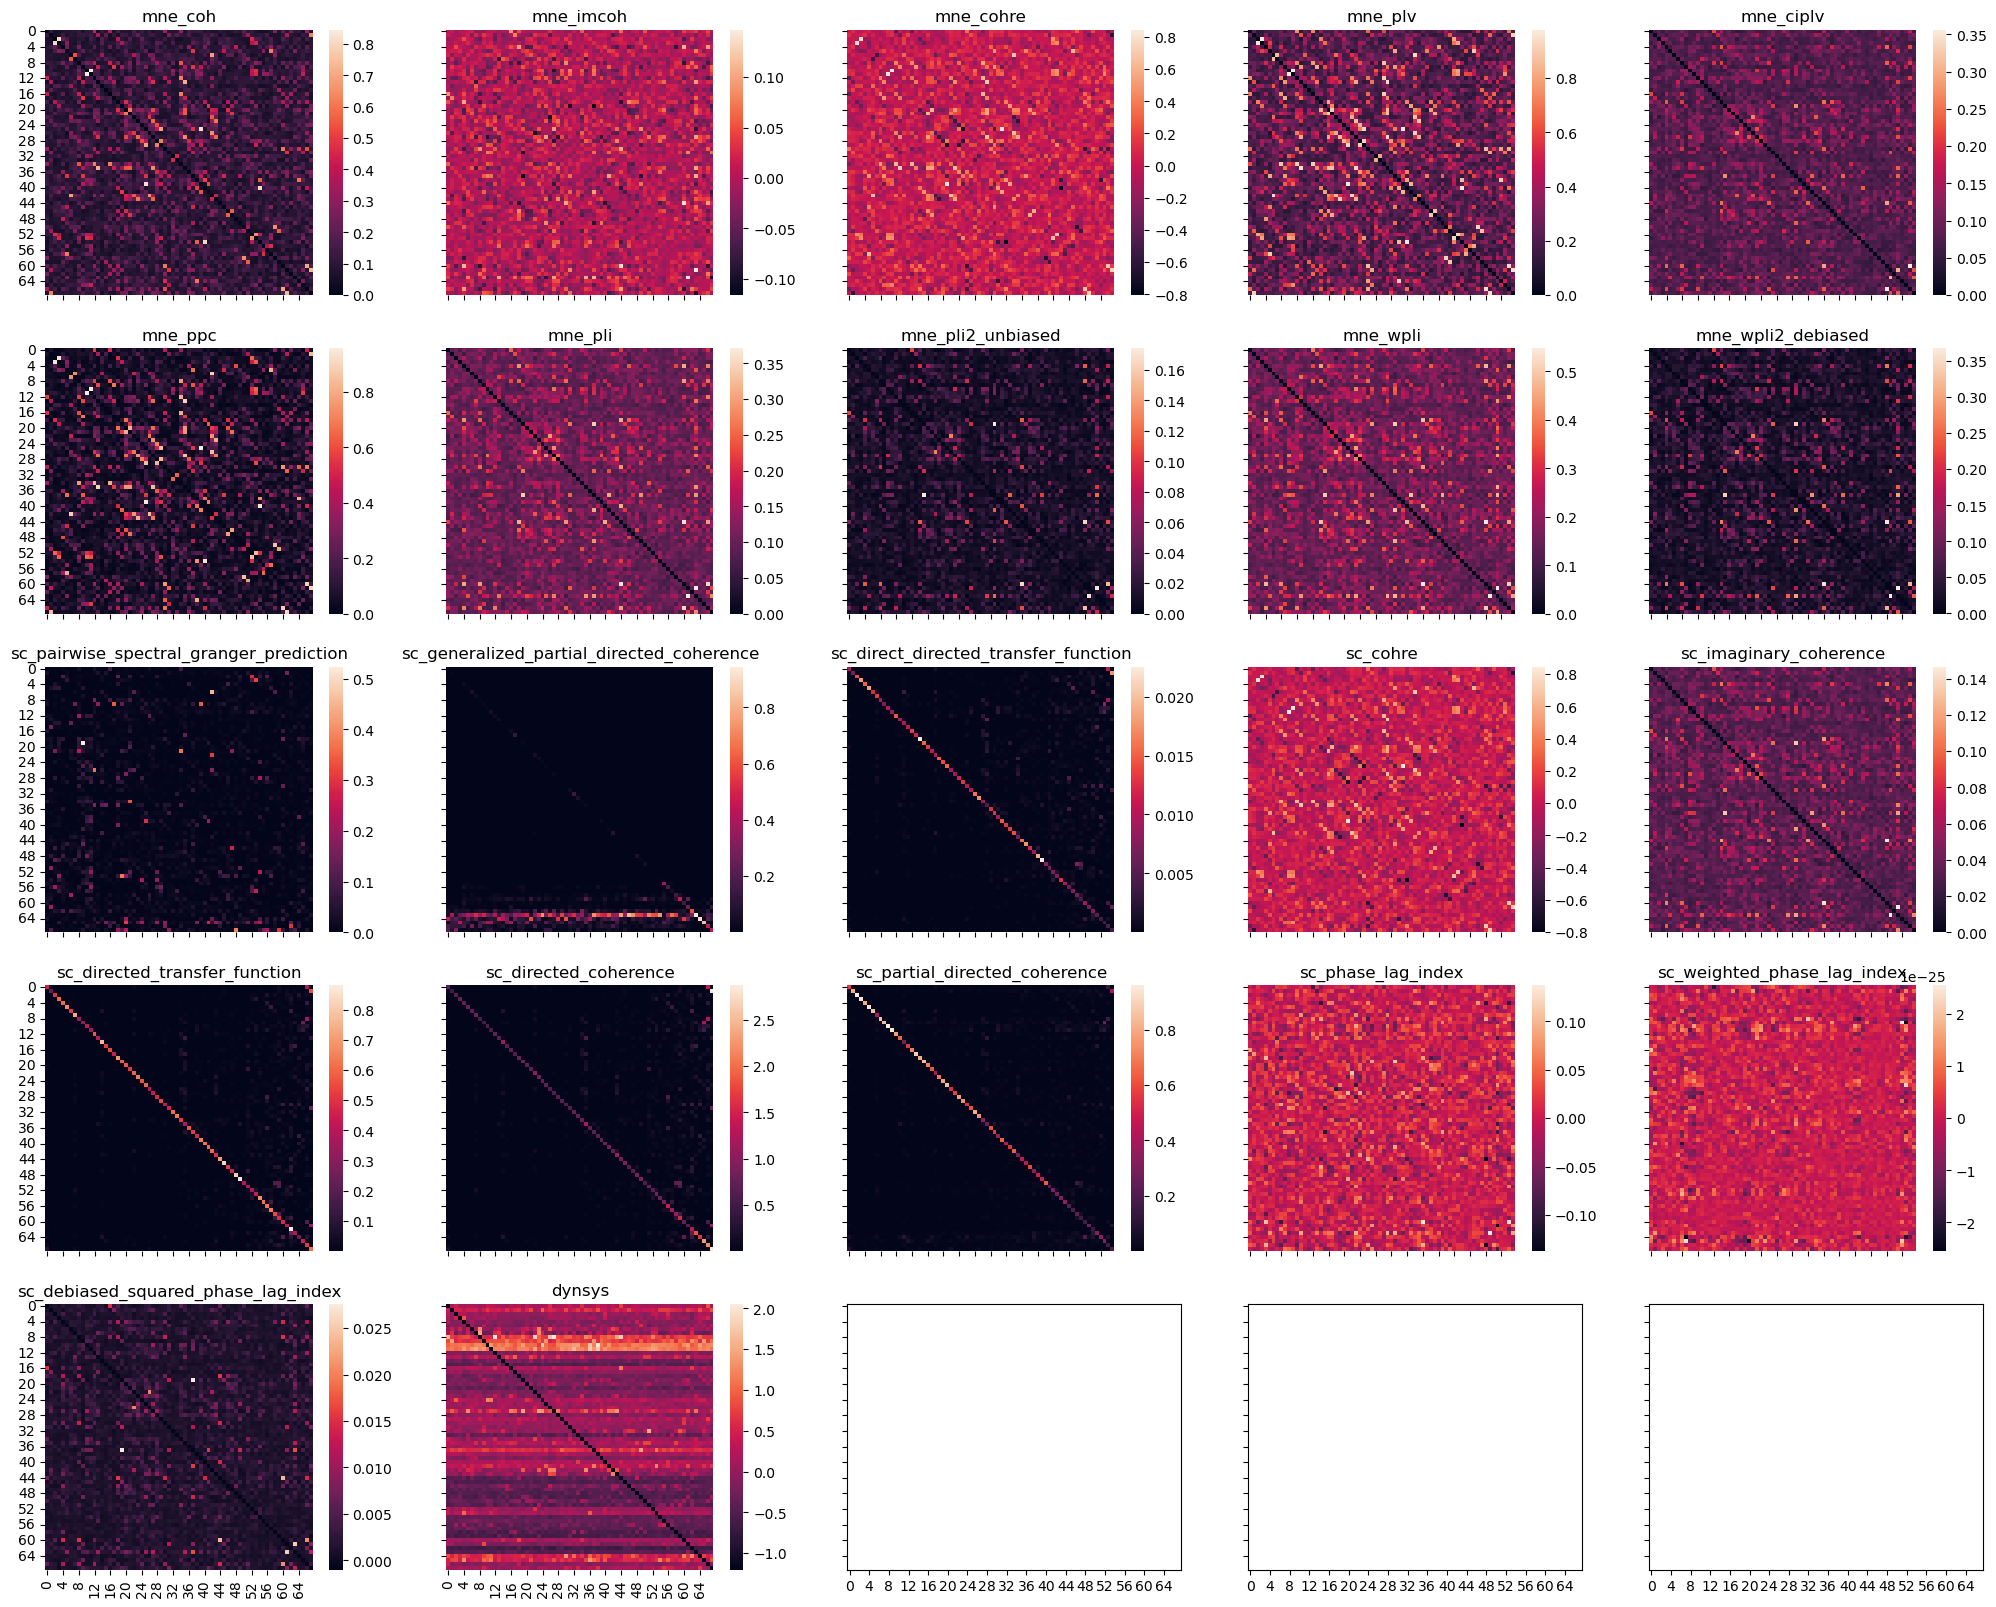

In [16]:
fig, axes = plt.subplots(5, 5, figsize=(25, 20), sharex=True, sharey=True)
for raveled_con_mat, method, ax in zip(combined_dat, all_methods, axes.ravel()):
    con_mat = raveled_con_mat.reshape(68, 68)
    sns.heatmap(con_mat, ax=ax)
    ax.set_title(method)

In [3]:
!pip install -q spectral_connectivity

In [17]:
from pymatreader import read_mat
import seaborn as sns
import xarray as xr
import mne
from mne_connectivity import spectral_connectivity_epochs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from spectral_connectivity import Multitaper, Connectivity
import gc

In [18]:
data = read_mat("coupling_strengths.mat")
data["Coupling_strengths"].shape

sources_nc = xr.open_dataset("sub-s601_ses-m12_eeg_qcr_source_labels.nc")
sfreq = 500

In [19]:
# Needed to remove lru_cache usage from the connectivity.py file in order to control memory usage
methods_kramer = [  #'phase_locking_value',         # Use too much memory
                    #'pairwise_phase_consistency',  # Use too much memory
                    #'canonical_coherence',         # Require additional parameterization       
                    #'group_delay',                 # Raise an exception
                    #'debiased_squared_weighted_phase_lag_index' # Return only zeros
                    'pairwise_spectral_granger_prediction',
                    'generalized_partial_directed_coherence', 
                    'direct_directed_transfer_function', 
                    #'coherency', 
                    #'imaginary_coherence',
                    #'directed_transfer_function',
                    #'directed_coherence', 
                    #'partial_directed_coherence',     
                    #'phase_lag_index', 
                    #'weighted_phase_lag_index', 
                    #'debiased_squared_phase_lag_index'
                    ]

kramer_cons = []
for method in methods_kramer:
    print(method)

    m = Multitaper(time_series=sources_nc.to_array().squeeze().data.transpose(2, 0, 1),
                   sampling_frequency=sfreq)

    c = Connectivity(fourier_coefficients=m.fft(),
                     frequencies=m.frequencies,
                     time=m.time)    
    
    con = getattr(c, method)()
    kramer_cons.append(np.nan_to_num(con.squeeze().mean(0), 0))    
    
    del m
    del c
    del con
    gc.collect()    

pairwise_spectral_granger_prediction
generalized_partial_directed_coherence
direct_directed_transfer_function


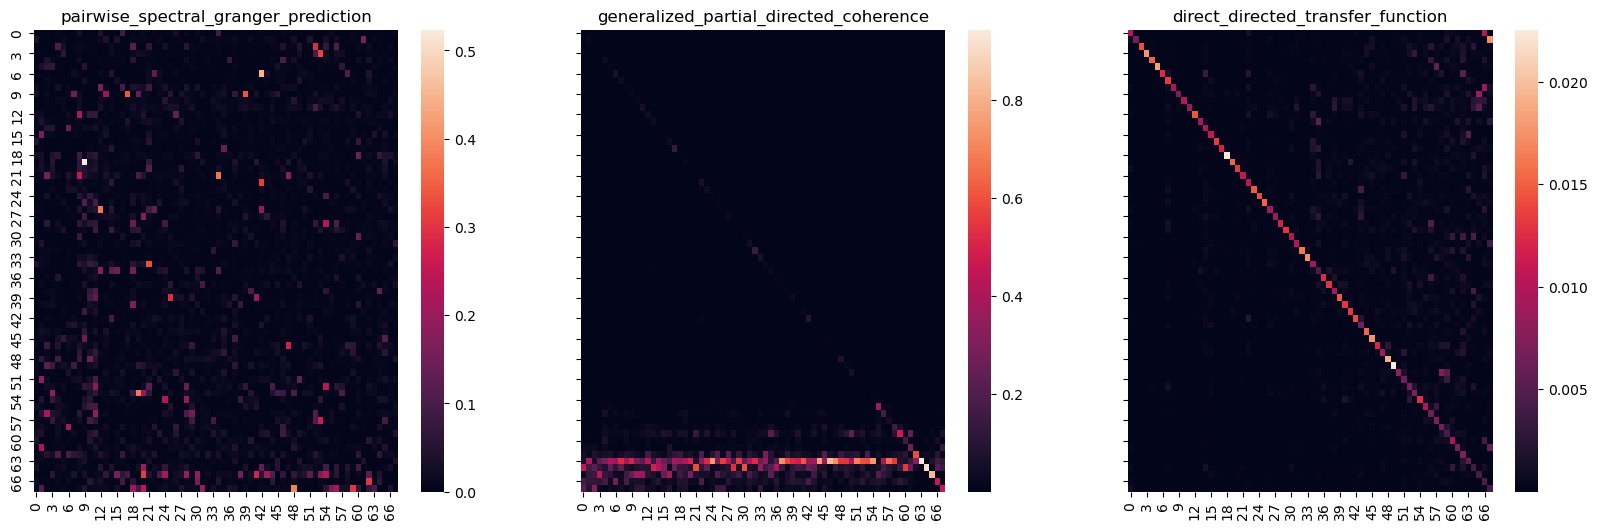

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
all_dat = []
for con_mat, method, ax in zip(kramer_cons, methods_kramer, axes.ravel()):
    sns.heatmap(con_mat, ax=ax)
    ax.set_title(method)
    all_dat.append(con_mat.ravel())

In [21]:
mne_methods = ['coh', 'ciplv']
mne_cons = spectral_connectivity_epochs(sources_nc.to_array().squeeze().data, 
                                        method=mne_methods, sfreq=sfreq, mode='multitaper', 
                                        fmin=None, fmax=np.inf, fskip=0, faverage=False, 
                                        tmin=None, tmax=None, mt_bandwidth=None, mt_adaptive=False, 
                                        mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..0.998s for estimation (500 points)
    frequencies: 5.0Hz..250.0Hz (246 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, ciPLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivi

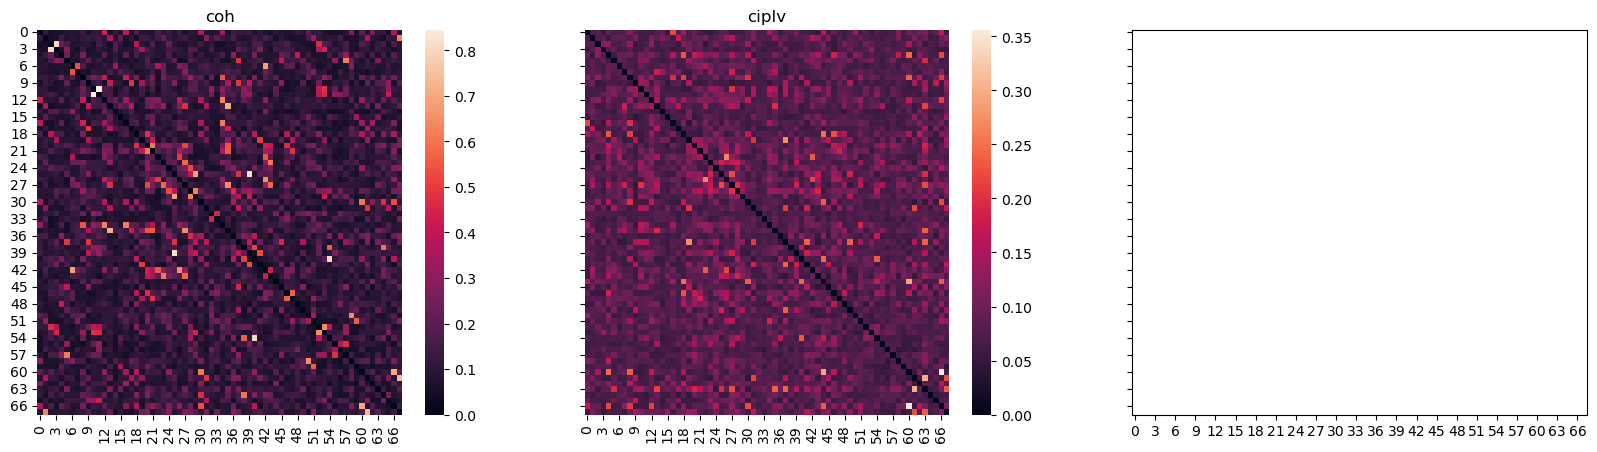

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
mne_all_dat = []
for con_mat, method, ax in zip(mne_cons, mne_cons[0].method, axes.ravel()):
    mat = con_mat.get_data("dense").mean(2) + con_mat.get_data("dense").mean(2).T
    sns.heatmap(mat, ax=ax)
    ax.set_title(method)
    mne_all_dat.append(mat.ravel())

In [23]:
all_methods = []

for method in mne_methods:
    all_methods.append("mne_" + method)
for method in methods_kramer:
    all_methods.append("sc_" + method)
all_methods.append("dynsys")

combined_dat = mne_all_dat.copy()
for con, method in zip(kramer_cons, methods_kramer):
    combined_dat.append(con.ravel())
    
combined_dat.append(data["Coupling_strengths"].mean(2).ravel())

In [24]:
methods_dict = {'mne_coh' : "Coh",
                'mne_ciplv' : "ciPLV",
                'sc_pairwise_spectral_granger_prediction': "PSGP",
                'sc_generalized_partial_directed_coherence': "GPDC",
                'sc_direct_directed_transfer_function': "dDTF",
                'dynsys': "DynSys"}

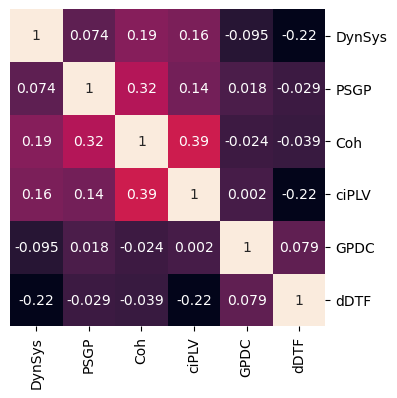

In [25]:
plt_dat = np.round(pd.DataFrame(np.array(combined_dat).T,
                   columns = [methods_dict[m] for m in all_methods]).corr(), 3)
g = sns.clustermap(plt_dat, annot=True, cbar_pos=None,  figsize=(4, 4))
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.tight_layout(rect=[-0.2, -0.02, 1.02, 1.2], w_pad=0.0, h_pad=0.0)

g.fig.savefig("correl_mat.png", dpi=300)

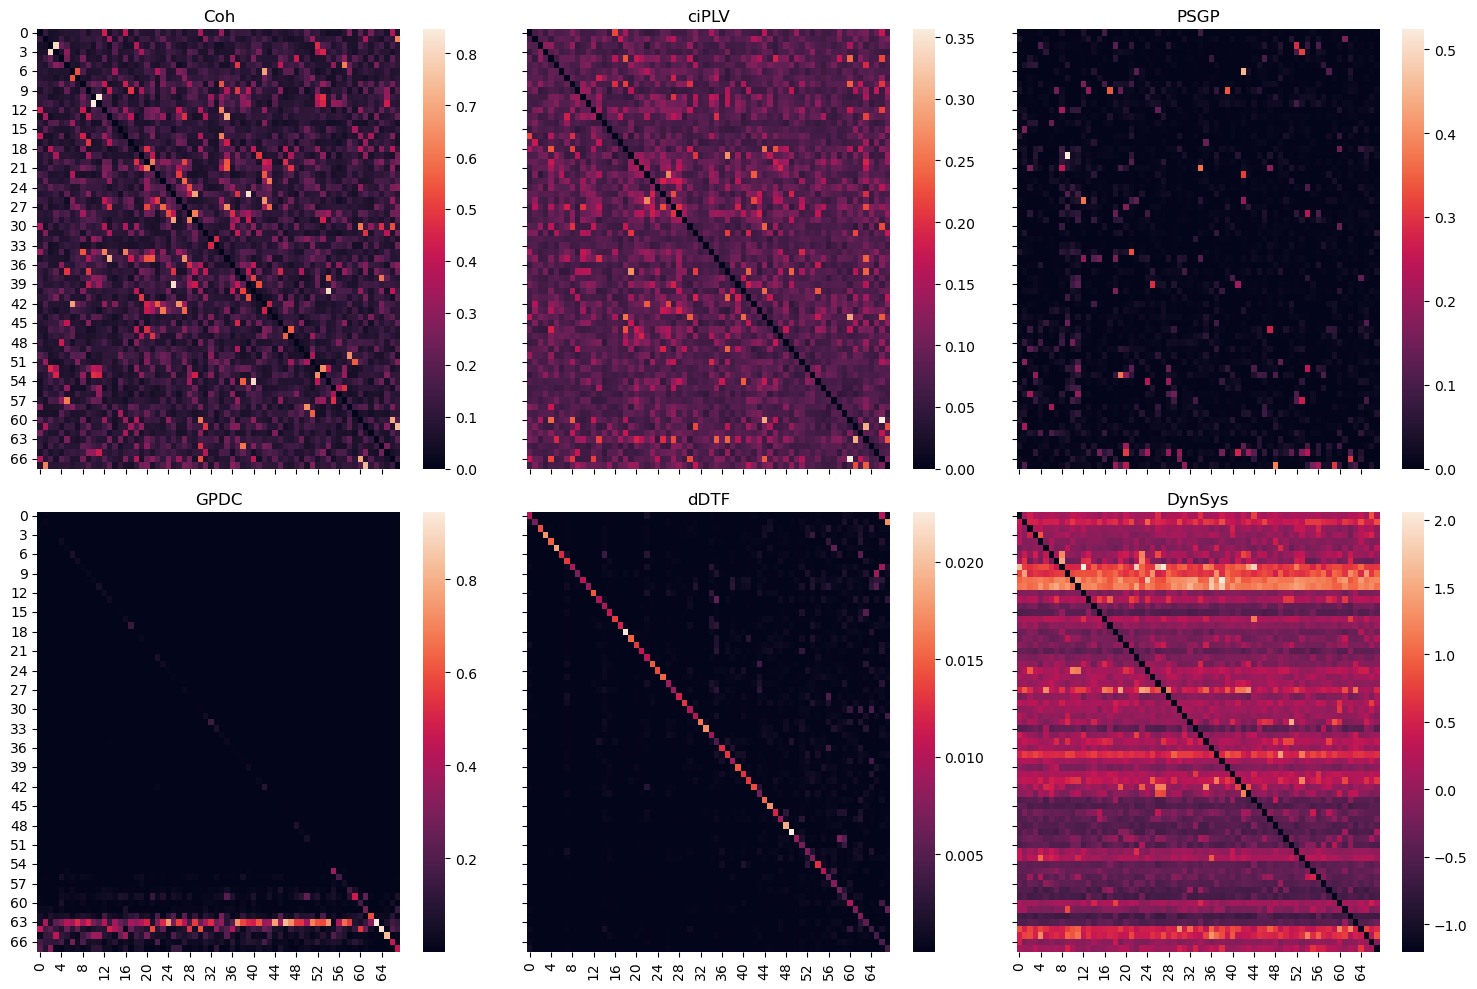

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
for raveled_con_mat, method, ax in zip(combined_dat, [methods_dict[m] for m in all_methods], axes.ravel()):
    con_mat = raveled_con_mat.reshape(68, 68)
    sns.heatmap(con_mat, ax=ax)
    ax.set_title(method)
    
fig.tight_layout()
fig.savefig("con_mat.png", dpi=300)

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne_connectivity import spectral_connectivity_epochs
from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle

In [30]:
# First, we reorder the labels based on their location in the left hemi
label_names = sources_nc.region.values

labels = mne.read_labels_from_annot('fsaverage', parc='aparc')
fs_label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]
fs_lh_labels = [name for name in fs_label_names if name.endswith('lh')]



# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = fs_lh_labels.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

for raveled_con_mat, method, ax in zip(combined_dat, all_methods, axes.ravel()):
    # Plot the graph using node colors from the FreeSurfer parcellation. We only
    # show the 300 strongest connections.
    con = raveled_con_mat.reshape([int(np.sqrt(raveled_con_mat.shape))]*2)
    fig, axes = plot_connectivity_circle(con, ['']*len(label_names), n_lines=300,
                             node_angles=node_angles, #node_colors=label_colors,
                             title=method, colorbar=False)
    fig.tight_layout()
    fig.savefig(f"con_graph_{method}.png", dpi=150)


Reading labels from parcellation...


KeyError: 'Key "SUBJECTS_DIR" not found in the environment or in the the mne-python config file (C:\\Users\\erikc\\.mne\\mne-python.json). Try either os.environ["SUBJECTS_DIR"] = VALUE for a temporary solution, or mne.utils.set_config("SUBJECTS_DIR", VALUE, set_env=True) for a permanent one. You can also set the environment variable before running python.'

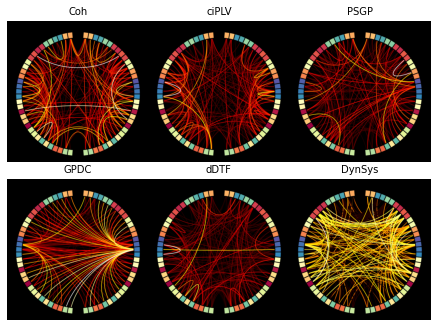

In [109]:
import matplotlib.image as mpimg


margin = 200
fig, axes = plt.subplots(2, 3, figsize=(6, 4.6),  facecolor='white')
for method, ax in zip(all_methods, axes.ravel()):
    img = mpimg.imread(f"con_graph_{method}.png")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(frame_on=False)
    
    ax.imshow(img[margin:-margin, margin:-margin])   
    ax.set_title(methods_dict[method], fontsize=10)      
    ax.set_aspect(1)    
    
fig.tight_layout(rect=[-0.01, -0.02, 1.02, 1.02], w_pad=0.0, h_pad=0.0)
fig.savefig("con_graphs.png", dpi=300)



/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_21286/2353383006.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig5.tight_layout(rect=[-0.01, -0.2, 1.02, 1.2], w_pad=0.0, h_pad=0.0)


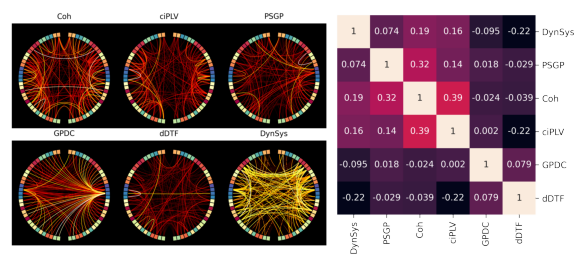

In [119]:
import matplotlib.image as mpimg

fig5 = plt.figure(constrained_layout=True, figsize=(8, 3.8), facecolor='white')
spec5 = fig5.add_gridspec(ncols=2, nrows=1, width_ratios=[0.56, 0.44])
ax1 = fig5.add_subplot(spec5[0, 0])
ax2 = fig5.add_subplot(spec5[0, 1])

img = mpimg.imread("con_graphs.png")
ax1.imshow(img)   
img = mpimg.imread("correl_mat.png")
ax2.imshow(img)   

for ax in [ax1, ax2]:
    ax.set(xticks=[], yticks=[])
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)

fig5.tight_layout(rect=[-0.01, -0.2, 1.02, 1.2], w_pad=0.0, h_pad=0.0)
fig5.savefig("aim3.png", dpi=300)

In [ ]:
#http://brain.labsolver.org/diffusion-mri-templates/tractography : in AAL; FreeSurfer do no support AAL